In [1]:
import xarray as xr
from matplotlib import pyplot as plt
import numpy as np
%load_ext autoreload
%autoreload 2
import pei.laborfunctions as lf
from cartopy import crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import matplotlib.cm as cm
from dask.diagnostics import ProgressBar
plt.style.use('/home/aos/kyan/.config/matplotlib/esm2m.mplstyle')

# Load ToEs

In [2]:
#land mask data
#ESM2M
land_area_esm2m = xr.open_dataset('../data/processed/GFDL/esm2m.land_area')['land_area']
land_mask_esm2m = land_area_esm2m>0

#CESM2
land_area_cesm2 = xr.open_dataset('../data/processed/CESM2/cesm2.land_area')['__xarray_dataarray_variable__'].isel(ensemble=0)
land_mask_cesm2 = land_area_cesm2>0

In [3]:
# Population data
ds_pop_esm2m = xr.open_dataset('../data/processed/GFDL/population_regrid_esm2m_2.nc')['population']
ds_pop_esm2m = ds_pop_esm2m.where(np.isfinite(ds_pop_esm2m),0)

# Population data
ds_pop_cesm2 = xr.open_dataset('../data/processed/CESM2/population_regrid_cesm2_2.nc')['population']
ds_pop_cesm2 = ds_pop_cesm2.where(np.isfinite(ds_pop_cesm2),0)

In [4]:
#ToEs, masking out ocean
ds_toe_esm2m = xr.open_dataset('../data/processed/GFDL/hottestmonth_toes.nc').where(land_mask_esm2m,np.nan)
ds_toe_cesm2 = xr.open_dataset('../data/processed/CESM2/hottestmonth_toes.nc').where(land_mask_cesm2,np.nan)

In [5]:
# Delta temperature
deltat_esm2m = xr.open_dataarray('../data/processed/GFDL/deltatemp.nc')
deltat_cesm2 = xr.open_dataarray('../data/processed/CESM2/deltatemp.nc')

In [6]:
# Baseline data
ds_base_esm2m = xr.open_dataarray('../data/processed/GFDL/esm2m_baseline_hottestmonths.nc')
ds_base_cesm2 = xr.open_dataarray('../data/processed/CESM2/cesm2_baseline_hottestmonths.nc')

# Calculations

In [22]:
#Global land area emerged, CESM2
emerged_areas = (ds_toe_cesm2.mean('ensemble')<2101)*land_area_cesm2
emerged_frac = emerged_areas.sum()/land_area_cesm2.sum()
emerged_frac

<xarray.Dataset>
Dimensions:  ()
Data variables:
    0.75     float32 0.48401064
    0.5      float32 0.33835685

In [23]:
#Global land area emerged, ESM2M
emerged_areas = (ds_toe_esm2m.mean('ensemble')<2101)*land_area_esm2m
emerged_frac = emerged_areas.sum()/land_area_esm2m.sum()
emerged_frac

<xarray.Dataset>
Dimensions:  ()
Coordinates:
    pfull    float64 ...
Data variables:
    0.75     float32 0.3602288
    0.5      float32 0.18881628

In [44]:
ds_cesm2_mean = ds_toe_cesm2.interp_like(ds_toe_esm2m).mean('ensemble') 
ds_esm2m_mean = ds_toe_esm2m.mean('ensemble')

#Only cells that emerge
ds_cesm2_mean = ds_cesm2_mean.where(ds_cesm2_mean<=2100,other=np.NaN)
ds_esm2m_mean = ds_esm2m_mean.where(ds_esm2m_mean<=2100,other=np.NaN)
ds_diff = ds_esm2m_mean - ds_cesm2_mean
ds_diff.weighted(land_area_esm2m).mean(skipna=True)

/home/aos/kyan/miniconda3/envs/pei/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


<xarray.Dataset>
Dimensions:  ()
Coordinates:
    pfull    float64 996.1
Data variables:
    0.75     float64 12.71
    0.5      float64 12.64

In [10]:
#Percent of locations convergent within 20 years, ESM2M
emerged_mask = (ds_toe_esm2m.mean('ensemble')<2101)
emerged_areas = (emerged_mask*land_area_esm2m).sum()
range_esm2m = ds_toe_esm2m.max('ensemble') - ds_toe_esm2m.min('ensemble')
convergent_areas = ((range_esm2m<30)*(ds_toe_esm2m.max('ensemble')<2101)*land_area_esm2m).sum()
convergent_areas/emerged_areas

/home/aos/kyan/miniconda3/envs/pei/lib/python3.8/site-packages/xarray/core/nputils.py:215: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/home/aos/kyan/miniconda3/envs/pei/lib/python3.8/site-packages/xarray/core/nputils.py:215: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


<xarray.Dataset>
Dimensions:  ()
Coordinates:
    pfull    float64 996.1
Data variables:
    0.75     float32 0.3793619
    0.5      float32 0.116241775

In [11]:
#Percent of locations convergent within 20 years, ESM2M
emerged_mask = (ds_toe_cesm2.mean('ensemble')<2101)
emerged_areas = (emerged_mask*land_area_cesm2).sum()
range_cesm2 = ds_toe_cesm2.max('ensemble') - ds_toe_cesm2.min('ensemble')
convergent_areas = ((range_cesm2<30)*(ds_toe_cesm2.max('ensemble')<2101)*land_area_cesm2).sum()
convergent_areas/emerged_areas

/home/aos/kyan/miniconda3/envs/pei/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/aos/kyan/miniconda3/envs/pei/lib/python3.8/site-packages/xarray/core/nputils.py:215: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


<xarray.Dataset>
Dimensions:  ()
Data variables:
    0.75     float32 0.6376032
    0.5      float32 0.6364113

# Calculate ToEs

In [26]:
# Hottest months data
ds_esm2m = xr.open_dataarray('../data/processed/GFDL/esm2m_future_hottestmonths.nc')
ds_cesm2 = xr.open_dataarray('../data/processed/CESM2/cesm2_future_hottestmonths.nc')

In [27]:
# Labor reduction thresholds used to define ToE
labor_thres = [0.75,0.5]

# Calculate ToEs for all grid cells and ensemble members
ds_toe_esm2m = lf.toe_summer(ds_esm2m,ds_base_esm2m,labor_thres)
ds_toe_cesm2 = lf.toe_summer(ds_cesm2,ds_base_cesm2,labor_thres)

# Spatial Maps

/home/aos/kyan/miniconda3/envs/pei/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


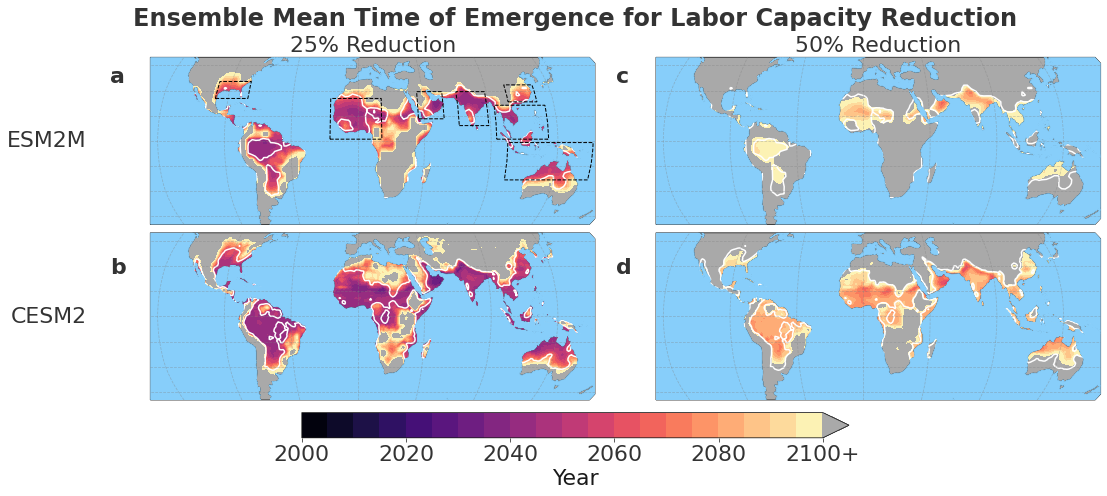

In [95]:
lf.spatial_toe(ds_toe_esm2m,ds_toe_cesm2,ds_base_esm2m,ds_base_cesm2,'Ensemble Mean Time of Emergence for Labor Capacity Reduction',['0.75','0.5'])
#plt.savefig('spatial_toe_esm2m.png',dpi=300)

# ToE Range

/home/aos/kyan/miniconda3/envs/pei/lib/python3.8/site-packages/xarray/core/nputils.py:215: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/home/aos/kyan/miniconda3/envs/pei/lib/python3.8/site-packages/xarray/core/nputils.py:215: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/home/aos/kyan/miniconda3/envs/pei/lib/python3.8/site-packages/xarray/core/nputils.py:215: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/home/aos/kyan/miniconda3/envs/pei/lib/python3.8/site-packages/xarray/core/nputils.py:215: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


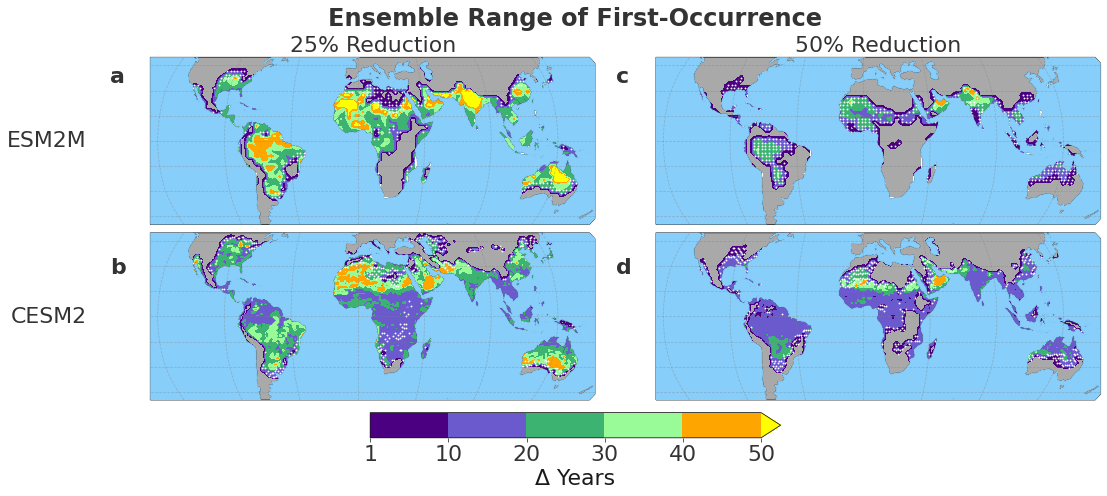

In [23]:
lf.range_plot(ds_toe_esm2m,ds_toe_cesm2,'Ensemble Range of First-Occurrence',['0.75','0.5'])

# Time Series

In [34]:
def frac_emerge_plot(ds_toe_esm2m,ds_toe_cesm2,ds_pop_esm2m,ds_pop_cesm2,title,ax,ylabel=False,xlabel=False):
    '''Plot a single time series of fraction of population emerged'''
    
    thres = ['0.75','0.5']
    
    # Calculate fraction of population that has emerged
    ds_frac_esm2m = lf.frac_emerge(ds_toe_esm2m,ds_pop_esm2m)/ds_pop_esm2m.sum(['lat','lon'])
    ds_frac_cesm2 = lf.frac_emerge(ds_toe_cesm2,ds_pop_cesm2)/ds_pop_cesm2.sum(['lat','lon'])

    # Thresholds for ESM2M
    # Plot ensemble envelope (x,y_min,y_max)
    ax.fill_between(ds_frac_esm2m['year'],ds_frac_esm2m[thres[0]].min(dim='ensemble'),ds_frac_esm2m[thres[0]].max(dim='ensemble'),alpha=0.15,color='cornflowerblue')
    ds_frac_esm2m[thres[0]].mean(dim='ensemble').plot(ax=ax,color='cornflowerblue',linewidth=3)

    ax.fill_between(ds_frac_esm2m['year'],ds_frac_esm2m[thres[1]].min(dim='ensemble'),ds_frac_esm2m[thres[1]].max(dim='ensemble'),alpha=0.15,color='mediumblue')
    ds_frac_esm2m[thres[1]].mean(dim='ensemble').plot(ax=ax,color='mediumblue',linewidth=3)

    # Thresholds for CESM2
    ax.fill_between(ds_frac_cesm2['year'],ds_frac_cesm2[thres[0]].min(dim='ensemble'),ds_frac_cesm2[thres[0]].max(dim='ensemble'),alpha=0.4,color='lightcoral')
    ds_frac_cesm2[thres[0]].mean(dim='ensemble').plot(ax=ax,color='lightcoral',linewidth=3)

    ax.fill_between(ds_frac_cesm2['year'],ds_frac_cesm2[thres[1]].min(dim='ensemble'),ds_frac_cesm2[thres[1]].max(dim='ensemble'),alpha=0.4,color='tab:red')
    ds_frac_cesm2[thres[1]].mean(dim='ensemble').plot(ax=ax,color='tab:red',linewidth=3)
    
    # Set labels, limits, title
    if xlabel:
        ax.set_xlabel('Year',fontsize=22,fontweight='bold')
    else:
        ax.set_xlabel(None)
    if ylabel:
        ax.set_ylabel('Fraction of Population',fontsize=22,fontweight='bold')
    else:
        ax.set_ylabel(None)
    ax.set_ylim([0,1])
    ax.set_xlim([2010,2100])
    ax.set_xticks(np.linspace(2020,2100,5))
    ax.set_title(title,fontsize=26,fontweight='bold')

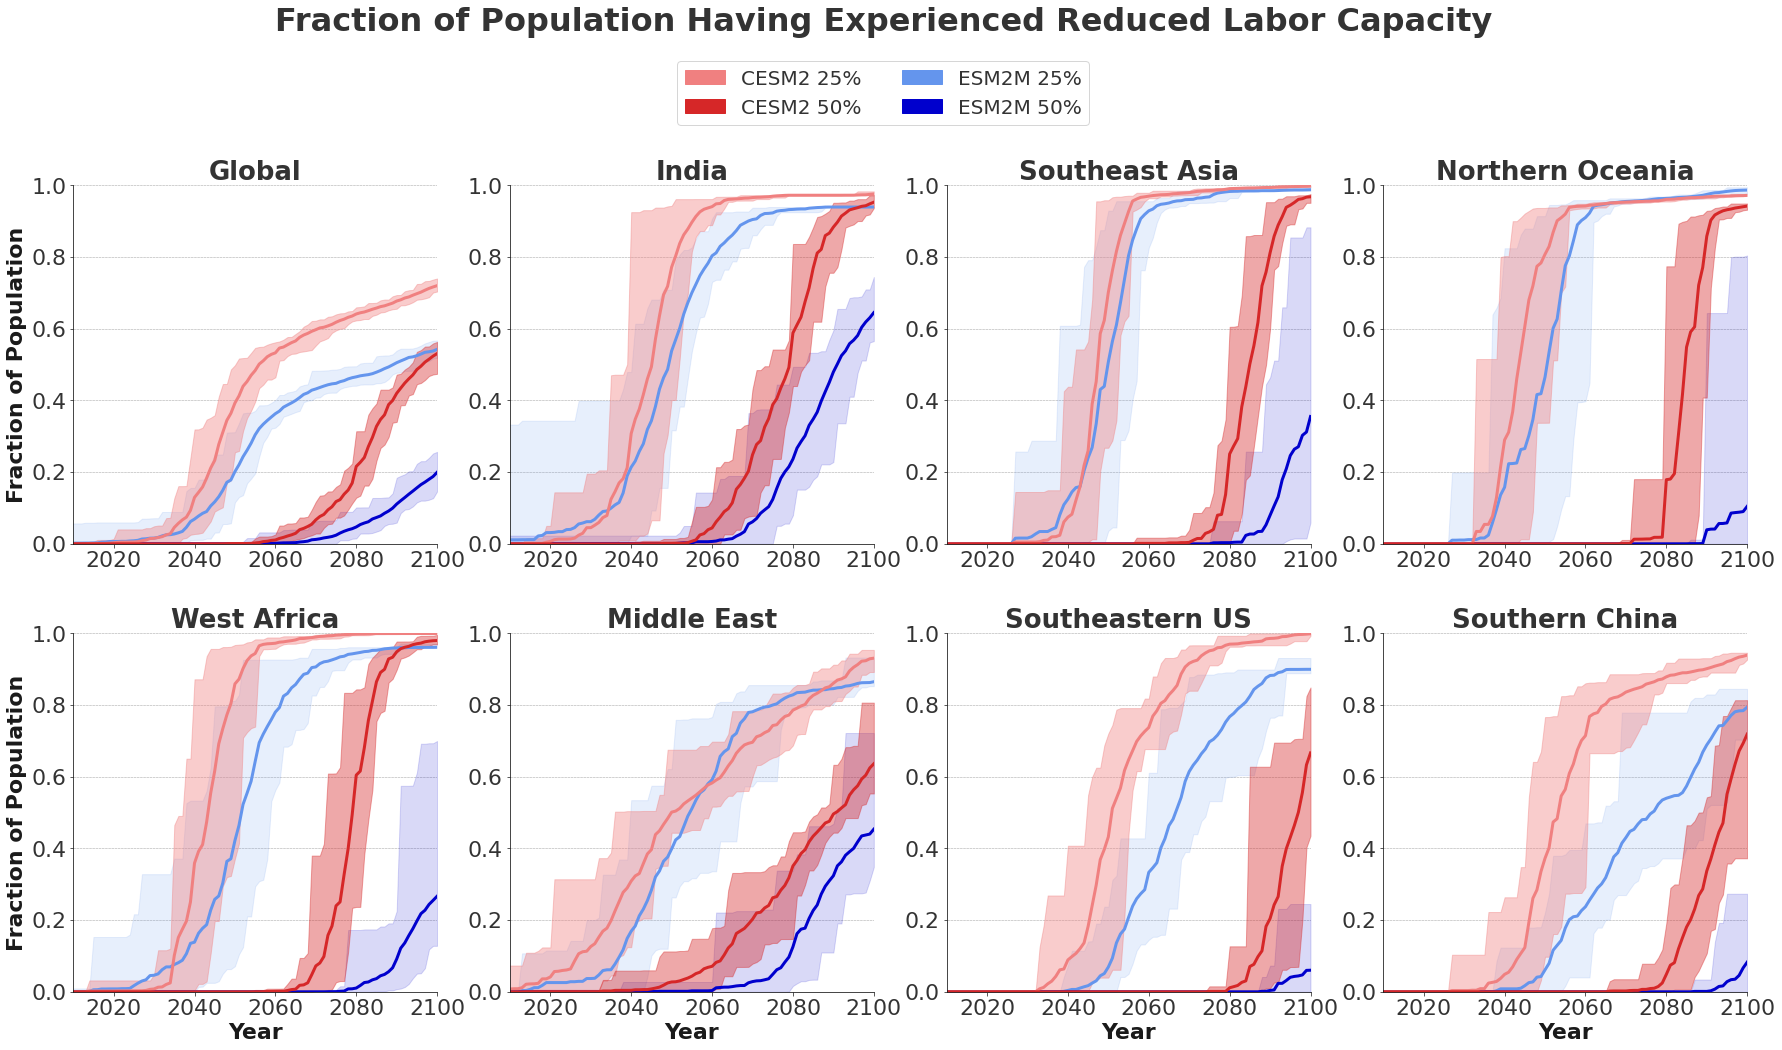

In [41]:
# Regions to plot
regions = ['Global','India','Southeast Asia','Northern Oceania','West Africa','Middle East','Southeastern US','Southern China']

# Create figure and axes
fig, axs = plt.subplots(figsize=(30,16),nrows=2,ncols=4)

# Running counter to determine axis
index = 0

# Loop through regions
for region in regions:
    # Get correct axis
    ax = axs[int(index/4)][index%4]
    
    # Get ToE and population data for region
    toe_esm2m = lf.slice_region(ds_toe_esm2m,region,'GFDL')
    pop_esm2m = lf.slice_region(ds_pop_esm2m,region,'GFDL')
    toe_cesm2 = lf.slice_region(ds_toe_cesm2,region,'CESM2')
    pop_cesm2 = lf.slice_region(ds_pop_cesm2,region,'CESM2')
    
    # Call function to plot for this region
    xlabel = False
    ylabel = False
    if index>3:
        xlabel = True
    if (index%4)== 0:
        ylabel = True
    frac_emerge_plot(toe_esm2m,toe_cesm2,pop_esm2m,pop_cesm2,region,ax,ylabel,xlabel)
    index+=1

# Set legend
light_blue_patch = mpatches.Patch(color='cornflowerblue', label='ESM2M 25%')
dark_blue_patch = mpatches.Patch(color='mediumblue', label='ESM2M 50%')
light_red_patch = mpatches.Patch(color='lightcoral', label='CESM2 25%')
dark_red_patch = mpatches.Patch(color='tab:red', label='CESM2 50%')

# Create axis at top for legend
fig.subplots_adjust(top=0.825)
legend_ax = fig.add_axes([0.3, 0.865, 0.4, 0.08])
legend_ax.legend(handles=[light_red_patch,dark_red_patch,light_blue_patch,dark_blue_patch],ncol=2,loc='center');

# Make legend axis markings invisible 
legend_ax.set_frame_on(False)
legend_ax.grid(False)
legend_ax.tick_params(bottom=False,left=False,labelbottom=False,labelleft=False)

# Make sure plots don't overlap
fig.subplots_adjust(wspace=.2,hspace=.25)
fig.suptitle('Fraction of Population Having Experienced Reduced Labor Capacity',fontsize=32,fontweight='bold');
#plt.savefig('timeseries_emerge.png',dpi=200)

# Event Plot

In [36]:
regions = ['Southern China','Southeastern US','Middle East','West Africa','Northern Oceania','Southeast Asia','India']
thres = ['0.75','0.5']

esm2m_1 = xr.Dataset()
esm2m_2 = xr.Dataset()

for region in regions:
    ds_region = lf.slice_region(ds_toe_esm2m,region,'GFDL')
    ds_region = ds_region.where(ds_region<2101,np.nan)
    esm2m_1[region] = ds_region[thres[0]].weighted(ds_pop_esm2m).mean(['lat','lon'],skipna=True)
    esm2m_2[region] = ds_region[thres[1]].weighted(ds_pop_esm2m).mean(['lat','lon'],skipna=True)

esm2m_1 = esm2m_1.to_array(dim='region')
esm2m_2 = esm2m_2.to_array(dim='region')

ds_global = ds_toe_esm2m.where(ds_toe_esm2m<2101,np.nan)
esm2m_global_1 = ds_global[thres[0]].weighted(ds_pop_esm2m).mean(['lat','lon'],skipna=True)
esm2m_global_2 = ds_global[thres[1]].weighted(ds_pop_esm2m).mean(['lat','lon'],skipna=True)

In [37]:
cesm2_1 = xr.Dataset()
cesm2_2 = xr.Dataset()

for region in regions:
    ds_region = lf.slice_region(ds_toe_cesm2,region,'CESM2')
    ds_region = ds_region.where(ds_region<2101,np.nan)
    cesm2_1[region] = ds_region[thres[0]].weighted(ds_pop_cesm2).mean(['lat','lon'],skipna=True)
    cesm2_2[region] = ds_region[thres[1]].weighted(ds_pop_cesm2).mean(['lat','lon'],skipna=True)
    
cesm2_1 = cesm2_1.to_array(dim='region')
cesm2_2 = cesm2_2.to_array(dim='region')

ds_global = ds_toe_cesm2.where(ds_toe_cesm2<2101,np.nan)
cesm2_global_1 = ds_global[thres[0]].weighted(ds_pop_cesm2).mean(['lat','lon'],skipna=True)
cesm2_global_2 = ds_global[thres[1]].weighted(ds_pop_cesm2).mean(['lat','lon'],skipna=True)

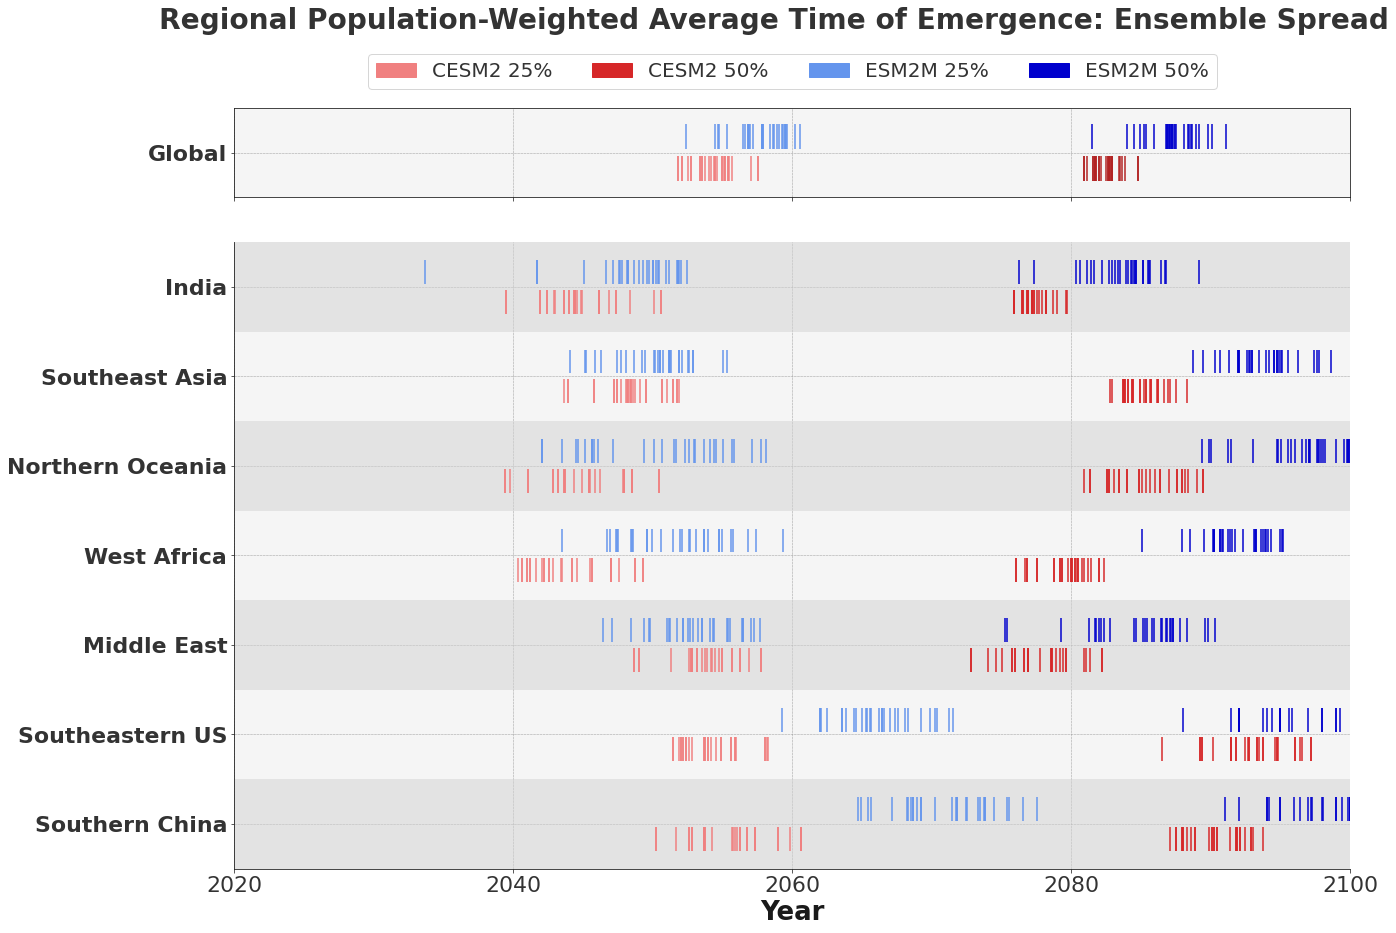

In [38]:
fig,axs=plt.subplots(nrows=2,figsize=(20,14),gridspec_kw={'height_ratios': [1,7]})

axs[1].eventplot(cesm2_1,orientation='horizontal',colors='lightcoral',linelengths=0.8,lineoffsets=[1,4,7,10,13,16,19]);
axs[1].eventplot(cesm2_2,orientation='horizontal',colors='tab:red',linelengths=0.8,lineoffsets=[1,4,7,10,13,16,19]);

axs[1].eventplot(esm2m_1,orientation='horizontal',colors='cornflowerblue',linelengths=0.8,lineoffsets=[2,5,8,11,14,17,20]);
axs[1].eventplot(esm2m_2,orientation='horizontal',colors='mediumblue',linelengths=0.8,lineoffsets=[2,5,8,11,14,17,20]);

locs = np.arange(1.5,25.5,3)
axs[1].set_yticks(locs)
axs[1].set_yticklabels(regions,fontweight='bold');
axs[1].set_xlim([2020,2100]);
axs[1].set_ylim([0,21])
axs[1].set_xticks(range(2020,2120,20))
axs[1].set_xlabel('Year',fontsize=26,fontweight='bold')
axs[1].grid(axis='x')
axs[1].set_facecolor('whitesmoke')

# Alternating background color
for i in range(0,24,6):
    plt.axhspan(i, i+3, facecolor='lightgray', alpha=0.5)

axs[0].eventplot(cesm2_global_1,orientation='horizontal',colors='lightcoral',linelengths=0.8,lineoffsets=[1]);
axs[0].eventplot(cesm2_global_2,orientation='horizontal',colors='tab:red',linelengths=0.8,lineoffsets=[1]);

axs[0].eventplot(esm2m_global_1,orientation='horizontal',colors='cornflowerblue',linelengths=0.8,lineoffsets=[2]);
axs[0].eventplot(esm2m_global_2,orientation='horizontal',colors='mediumblue',linelengths=0.8,lineoffsets=[2]);

axs[0].set_yticks([1.5])
axs[0].set_yticklabels(['Global'],fontweight='bold');
axs[0].set_xlim([2020,2100]);
axs[0].set_xticks(range(2020,2120,20))
axs[0].set_xticklabels([])
axs[0].grid(axis='x')
axs[0].set_facecolor('whitesmoke')
axs[0].spines['top'].set_visible(True)
axs[0].spines['right'].set_visible(True)

# Set legend
light_blue_patch = mpatches.Patch(color='cornflowerblue', label='ESM2M 25%')
dark_blue_patch = mpatches.Patch(color='mediumblue', label='ESM2M 50%')
light_red_patch = mpatches.Patch(color='lightcoral', label='CESM2 25%')
dark_red_patch = mpatches.Patch(color='tab:red', label='CESM2 50%')

axs[0].legend(handles=[light_red_patch,dark_red_patch,light_blue_patch,dark_blue_patch],ncol=5,fancybox=True,loc='lower center',bbox_to_anchor=(0.5,1.1));
fig.subplots_adjust(hspace=.125)
fig.suptitle('Regional Population-Weighted Average Time of Emergence: Ensemble Spread\n\n',fontsize=28,fontweight='bold');
#plt.savefig('barcode_toe.png',dpi=300)

# Old (w/ 10% threshold)

In [ ]:
def frac_emerge_plot(ds_toe_esm2m,ds_toe_cesm2,ds_pop_esm2m,ds_pop_cesm2,title,ax,ylabel=False,xlabel=False):
    '''Plot a single time series of fraction of population emerged'''
    
    thres = ['0.9','0.75','0.5']
    
    # Calculate fraction of population that has emerged
    ds_frac_esm2m = lf.frac_emerge(ds_toe_esm2m,ds_pop_esm2m)/ds_pop_esm2m.sum(['lat','lon'])
    ds_frac_cesm2 = lf.frac_emerge(ds_toe_cesm2,ds_pop_cesm2)/ds_pop_cesm2.sum(['lat','lon'])

    # Thresholds for ESM2M
    # Plot ensemble envelope (x,y_min,y_max)
    ax.fill_between(ds_frac_esm2m['year'],ds_frac_esm2m[thres[0]].min(dim='ensemble'),ds_frac_esm2m[thres[0]].max(dim='ensemble'),alpha=0.15,color='royalblue')
    # Plot ensemble mean
    ds_frac_esm2m[thres[0]].mean(dim='ensemble').plot(ax=ax,color='royalblue',linewidth=3)

    ax.fill_between(ds_frac_esm2m['year'],ds_frac_esm2m[thres[1]].min(dim='ensemble'),ds_frac_esm2m[thres[1]].max(dim='ensemble'),alpha=0.15,color='forestgreen')
    ds_frac_esm2m[thres[1]].mean(dim='ensemble').plot(ax=ax,color='forestgreen',linewidth=3)

    ax.fill_between(ds_frac_esm2m['year'],ds_frac_esm2m[thres[2]].min(dim='ensemble'),ds_frac_esm2m[thres[2]].max(dim='ensemble'),alpha=0.15,color='orange')
    ds_frac_esm2m[thres[2]].mean(dim='ensemble').plot(ax=ax,color='orange',linewidth=3)

    # Thresholds for CESM2
    ax.fill_between(ds_frac_cesm2['year'],ds_frac_cesm2[thres[0]].min(dim='ensemble'),ds_frac_cesm2[thres[0]].max(dim='ensemble'),alpha=0.4,facecolor='none',hatch='//',edgecolor='royalblue',linewidth=1.5)
    ds_frac_cesm2[thres[0]].mean(dim='ensemble').plot(ax=ax,color='royalblue',linestyle='dashed',linewidth=3)

    ax.fill_between(ds_frac_cesm2['year'],ds_frac_cesm2[thres[1]].min(dim='ensemble'),ds_frac_cesm2[thres[1]].max(dim='ensemble'),alpha=0.4,facecolor='none',hatch='//',edgecolor='forestgreen',linewidth=1.5)
    ds_frac_cesm2[thres[1]].mean(dim='ensemble').plot(ax=ax,color='forestgreen',linestyle='dashed',linewidth=3)

    ax.fill_between(ds_frac_cesm2['year'],ds_frac_cesm2[thres[2]].min(dim='ensemble'),ds_frac_cesm2[thres[2]].max(dim='ensemble'),alpha=0.4,facecolor='none',hatch='//',edgecolor='orange',linewidth=1.5)
    ds_frac_cesm2[thres[2]].mean(dim='ensemble').plot(ax=ax,color='orange',linestyle='dashed',linewidth=3)
    
    # Set labels, limits, title
    if xlabel:
        ax.set_xlabel('Year',fontsize=22,fontweight='bold')
    else:
        ax.set_xlabel(None)
    if ylabel:
        ax.set_ylabel('Fraction of Population',fontsize=22,fontweight='bold')
    else:
        ax.set_ylabel(None)
    ax.set_ylim([0,1])
    ax.set_xlim([2010,2100])
    ax.set_xticks(np.linspace(2020,2100,5))
    ax.set_title(title,fontsize=26,fontweight='bold')

In [ ]:
# Regions to plot
regions = ['Global','India','Northern South America','Southeast Asia','West Africa','Northern Oceania']

# Create figure and axes
fig, axs = plt.subplots(figsize=(26,16),nrows=2,ncols=3)

# Running counter to determine axis
index = 0

# Loop through regions
for region in regions:
    # Get correct axis
    ax = axs[int(index/3)][index%3]
    
    # Get ToE and population data for region
    toe_esm2m = lf.slice_region(ds_toe_esm2m,region,'GFDL')
    pop_esm2m = lf.slice_region(ds_pop_esm2m,region,'GFDL')
    toe_cesm2 = lf.slice_region(ds_toe_cesm2,region,'CESM2')
    pop_cesm2 = lf.slice_region(ds_pop_cesm2,region,'CESM2')
    
    # Call function to plot for this region
    xlabel = False
    ylabel = False
    if index>2:
        xlabel = True
    if (index%3)== 0:
        ylabel = True
    frac_emerge_plot(toe_esm2m,toe_cesm2,pop_esm2m,pop_cesm2,region,ax,ylabel,xlabel)
    index+=1

# Set legend
blue_patch = mpatches.Patch(color='royalblue', label='10% reduction')
green_patch = mpatches.Patch(color='forestgreen', label='25% reduction')
orange_patch = mpatches.Patch(color='orange', label='50% reduction')

solid_line = mlines.Line2D([], [], color='black', linestyle='solid', label='ESM2M mean')
dot_line = mlines.Line2D([], [], color='black', linestyle='dashed', label='CESM2 mean')

solid_patch = mpatches.Patch(color='black', label='ESM2M ensemble range')
hatch_patch = mpatches.Patch(fill=False, hatch='//', color='black', label='CESM2 ensemble range')

# Create axis at top for legend
fig.subplots_adjust(top=0.825)
legend_ax = fig.add_axes([0.3, 0.865, 0.4, 0.08])
legend_ax.legend(handles=[blue_patch,green_patch,orange_patch,solid_line,dot_line,solid_patch,hatch_patch],ncol=3,loc='center');

# Make legend axis markings invisible 
legend_ax.set_frame_on(False)
legend_ax.grid(False)
legend_ax.tick_params(bottom=False,left=False,labelbottom=False,labelleft=False)

# Make sure plots don't overlap
fig.subplots_adjust(wspace=.2,hspace=.25)
fig.suptitle('Fraction of Population Having Experienced Reduced Labor Capacity',fontsize=32,fontweight='bold');
plt.savefig('timeseries_emerge.png',dpi=200)

In [ ]:
regions = ['India','Northern South America','Southeast Asia','West Africa','Northern Oceania']
thres = ['0.9','0.75','0.5']

esm2m_1 = xr.Dataset()
esm2m_2 = xr.Dataset()
esm2m_3 = xr.Dataset()

for region in regions:
    ds_region = lf.slice_region(ds_toe_esm2m,region,'GFDL')
    esm2m_1[region] = ds_region[thres[0]].weighted(ds_pop_esm2m).mean(['lat','lon'])
    esm2m_2[region] = ds_region[thres[1]].weighted(ds_pop_esm2m).mean(['lat','lon'])
    esm2m_3[region] = ds_region[thres[2]].weighted(ds_pop_esm2m).mean(['lat','lon'])

esm2m_1 = esm2m_1.to_array(dim='region')
esm2m_2 = esm2m_2.to_array(dim='region')
esm2m_3 = esm2m_3.to_array(dim='region')

In [ ]:
cesm2_1 = xr.Dataset()
cesm2_2 = xr.Dataset()
cesm2_3 = xr.Dataset()

for region in regions:
    ds_region = lf.slice_region(ds_toe_cesm2,region,'CESM2')
    cesm2_1[region] = ds_region[thres[0]].weighted(ds_pop_cesm2).mean(['lat','lon'])
    cesm2_2[region] = ds_region[thres[1]].weighted(ds_pop_cesm2).mean(['lat','lon'])
    cesm2_3[region] = ds_region[thres[2]].weighted(ds_pop_cesm2).mean(['lat','lon'])
    
cesm2_1 = cesm2_1.to_array(dim='region')
cesm2_2 = cesm2_2.to_array(dim='region')
cesm2_3 = cesm2_3.to_array(dim='region')

In [ ]:
fig,ax=plt.subplots(figsize=(20,11))
ax.eventplot(esm2m_1,orientation='vertical',colors='royalblue',linelengths=0.8,lineoffsets=[1,4,7,10,13]);
ax.eventplot(esm2m_2,orientation='vertical',colors='forestgreen',linelengths=0.8,lineoffsets=[1,4,7,10,13]);
ax.eventplot(esm2m_3,orientation='vertical',colors='orange',linelengths=0.8,lineoffsets=[1,4,7,10,13]);

ax.eventplot(cesm2_1,orientation='vertical',colors='royalblue',linelengths=0.8,linestyles='dotted',lineoffsets=[2,5,8,11,14]);
ax.eventplot(cesm2_2,orientation='vertical',colors='forestgreen',linelengths=0.8,linestyles='dotted',lineoffsets=[2,5,8,11,14]);
ax.eventplot(cesm2_3,orientation='vertical',colors='orange',linelengths=0.8,linestyles='dotted',lineoffsets=[2,5,8,11,14]);

locs = np.arange(1.5,16.5,3)
ax.set_xticks(locs)
ax.set_xticklabels(['India','Northern\nSouth America','Southeast Asia','West Africa','Northern Oceania'],fontweight='bold');
ax.set_ylim([2000,2100]);
ax.set_ylabel('Year',fontsize=26,fontweight='bold')
ax.set_title('Regional Average Time of Emergence: Ensemble Spread\n\n',fontsize=28,fontweight='bold');

# Set legend
blue_patch = mpatches.Patch(color='royalblue', label='10% reduction')
green_patch = mpatches.Patch(color='forestgreen', label='25% reduction')
orange_patch = mpatches.Patch(color='orange', label='50% reduction')

solid_line = mlines.Line2D([], [], color='black', linestyle='solid', label='ESM2M')
dot_line = mlines.Line2D([], [], color='black', linestyle='dotted', label='CESM2')

ax.legend(handles=[blue_patch,green_patch,orange_patch,solid_line,dot_line],ncol=5,fancybox=True,loc='lower center',bbox_to_anchor=(0.5,1));
plt.savefig('barcode_toe.png',dpi=300)

# Temperature of Emergence

In [31]:
def temp_emerge_plot(ds_toe_esm2m,ds_toe_cesm2,ds_pop_esm2m,ds_pop_cesm2,title,ax,ylabel=False,xlabel=False):
    '''Plot a single time series of fraction of population emerged'''
    
    thres = ['0.75','0.5']
    
    # Calculate fraction of population that has emerged
    ds_frac_esm2m = lf.frac_emerge(ds_toe_esm2m,ds_pop_esm2m)/ds_pop_esm2m.sum(['lat','lon'])
    ds_frac_esm2m = ds_frac_esm2m.assign_coords({'temp':deltat_esm2m.sel(year=ds_frac_esm2m['year'])}).drop('year')
    
    ds_frac_cesm2 = lf.frac_emerge(ds_toe_cesm2,ds_pop_cesm2)/ds_pop_cesm2.sum(['lat','lon'])
    ds_frac_cesm2 = ds_frac_cesm2.assign_coords({'temp':deltat_cesm2.sel(year=ds_frac_cesm2['year'])}).drop('year')

    # Thresholds for ESM2M
    ax.scatter(ds_frac_esm2m['temp'],ds_frac_esm2m[thres[0]].mean('ensemble'),color='cornflowerblue',s=15,marker='o')
    ax.scatter(ds_frac_esm2m['temp'],ds_frac_esm2m[thres[1]].mean('ensemble'),color='mediumblue',s=15,marker='o')
    for ens in ds_frac_esm2m['ensemble']:
        ax.scatter(ds_frac_esm2m['temp'],ds_frac_esm2m[thres[0]].sel(ensemble=ens),color='cornflowerblue',s=3,marker='o',alpha=0.1)
        ax.scatter(ds_frac_esm2m['temp'],ds_frac_esm2m[thres[1]].sel(ensemble=ens),color='mediumblue',s=3,marker='o',alpha=0.1)

    # Thresholds for CESM2
    ax.scatter(ds_frac_cesm2['temp'],ds_frac_cesm2[thres[0]].mean('ensemble'),color='lightcoral',s=15,marker='o')
    ax.scatter(ds_frac_cesm2['temp'],ds_frac_cesm2[thres[1]].mean('ensemble'),color='tab:red',s=15,marker='o')
    for ens in ds_frac_cesm2['ensemble']:
        ax.scatter(ds_frac_cesm2['temp'],ds_frac_cesm2[thres[0]].sel(ensemble=ens),color='lightcoral',s=3,marker='o',alpha=0.1)
        ax.scatter(ds_frac_cesm2['temp'],ds_frac_cesm2[thres[1]].sel(ensemble=ens),color='tab:red',s=3,marker='o',alpha=0.1)
    
    # Set labels, limits, title
    if xlabel:
        ax.set_xlabel(u'Δ Temperature ($^\circ$C)',fontsize=22,fontweight='bold')
    else:
        ax.set_xlabel(None)
    if ylabel:
        ax.set_ylabel('Fraction of Population',fontsize=22,fontweight='bold')
    else:
        ax.set_ylabel(None)
    ax.set_ylim([0,1])
    ax.set_title(title,fontsize=26,fontweight='bold')

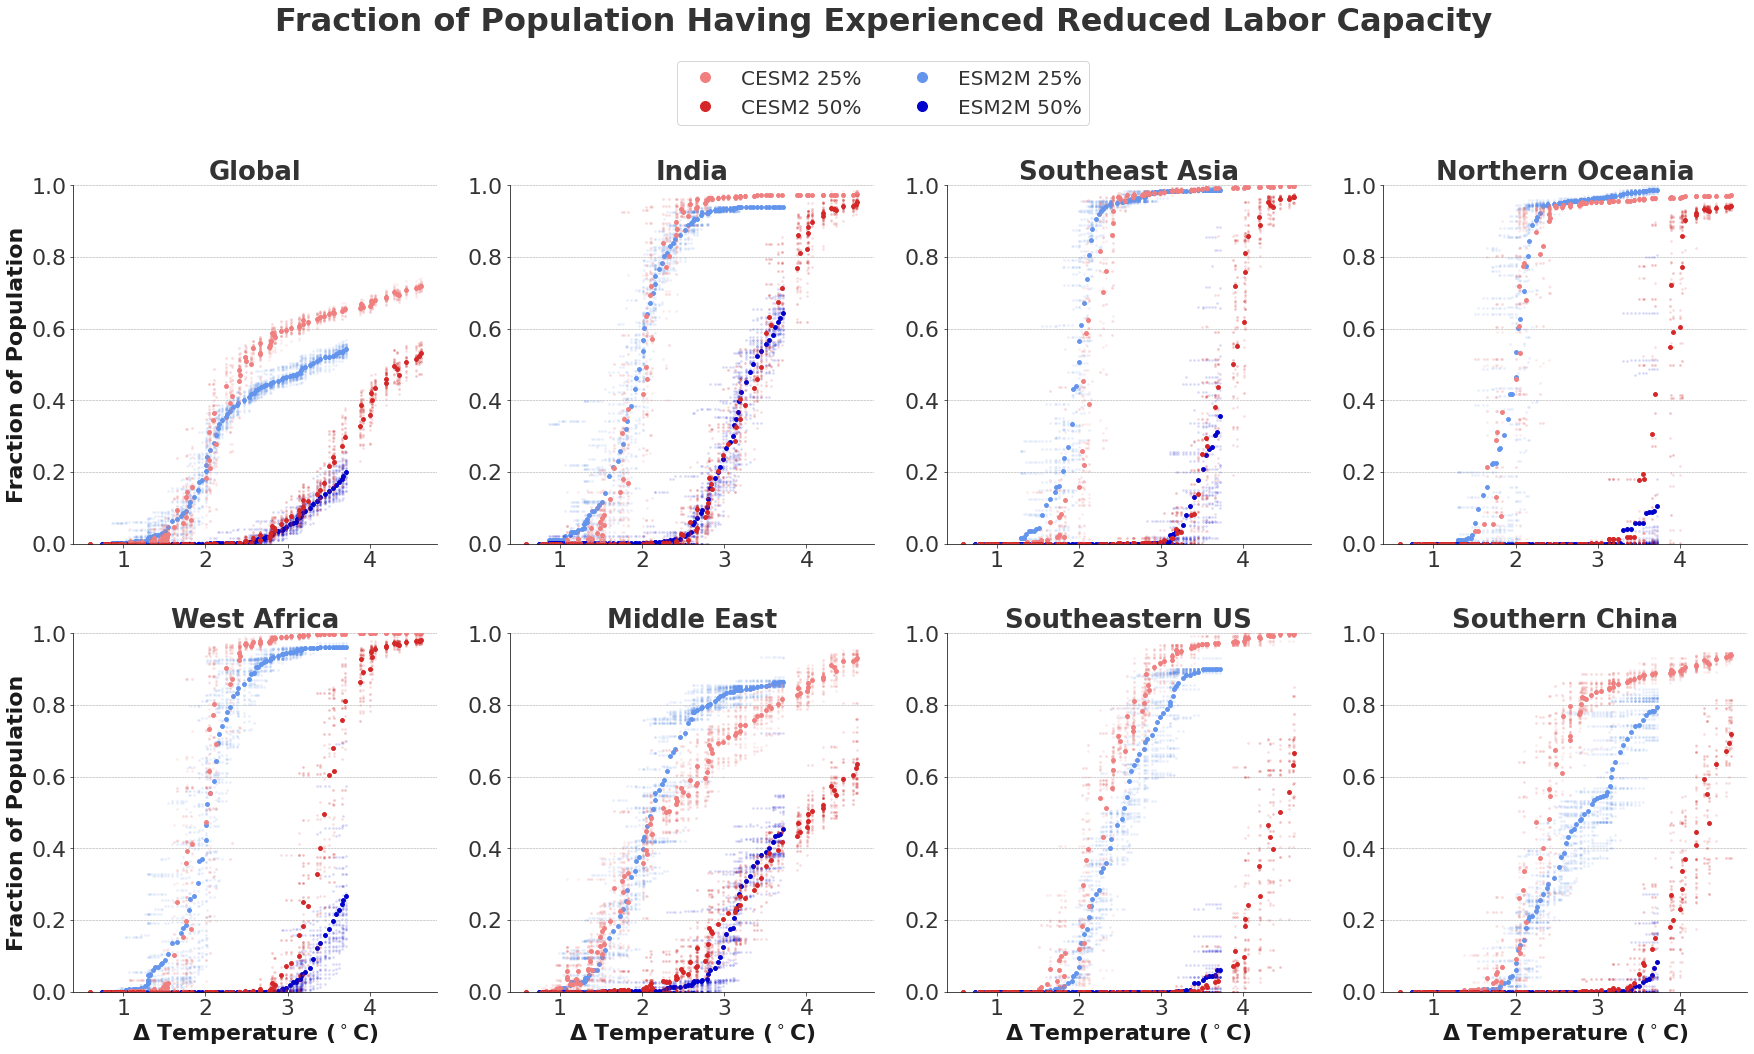

In [32]:
# Regions to plot
regions = ['Global','India','Southeast Asia','Northern Oceania','West Africa','Middle East','Southeastern US','Southern China']

# Create figure and axes
fig, axs = plt.subplots(figsize=(30,16),nrows=2,ncols=4)

# Running counter to determine axis
index = 0

# Loop through regions
for region in regions:
    # Get correct axis
    ax = axs[int(index/4)][index%4]
    
    # Get ToE and population data for region
    toe_esm2m = lf.slice_region(ds_toe_esm2m,region,'GFDL')
    pop_esm2m = lf.slice_region(ds_pop_esm2m,region,'GFDL')
    toe_cesm2 = lf.slice_region(ds_toe_cesm2,region,'CESM2')
    pop_cesm2 = lf.slice_region(ds_pop_cesm2,region,'CESM2')
    
    # Call function to plot for this region
    xlabel = False
    ylabel = False
    if index>3:
        xlabel = True
    if (index%4)== 0:
        ylabel = True
    temp_emerge_plot(toe_esm2m,toe_cesm2,pop_esm2m,pop_cesm2,region,ax,ylabel,xlabel)
    index+=1

# Set legend
light_blue = mlines.Line2D([], [], color='cornflowerblue', marker='o', markersize=10, linestyle='None', label='ESM2M 25%')
dark_blue = mlines.Line2D([], [], color='mediumblue', marker='o', markersize=10, linestyle='None', label='ESM2M 50%')

light_red = mlines.Line2D([], [], color='lightcoral', marker='o', markersize=10, linestyle='None', label='CESM2 25%')
dark_red = mlines.Line2D([], [], color='tab:red', marker='o', markersize=10, linestyle='None', label='CESM2 50%')

# Create axis at top for legend
fig.subplots_adjust(top=0.825)
legend_ax = fig.add_axes([0.3, 0.865, 0.4, 0.08])
legend_ax.legend(handles=[light_red,dark_red,light_blue,dark_blue],ncol=2,loc='center');

# Make legend axis markings invisible 
legend_ax.set_frame_on(False)
legend_ax.grid(False)
legend_ax.tick_params(bottom=False,left=False,labelbottom=False,labelleft=False)    
    
# Make sure plots don't overlap
fig.subplots_adjust(wspace=.2,hspace=.25)
fig.suptitle('Fraction of Population Having Experienced Reduced Labor Capacity',fontsize=32,fontweight='bold');

In [6]:
ds_frac_esm2m = lf.frac_emerge(ds_toe_esm2m,ds_pop_esm2m)/ds_pop_esm2m.sum(['lat','lon'])
ds_frac_esm2m = ds_frac_esm2m.assign_coords({'temp':deltat_esm2m.sel(year=ds_frac_esm2m['year'])}).drop('year')

ds_frac_cesm2 = lf.frac_emerge(ds_toe_cesm2,ds_pop_cesm2)/ds_pop_cesm2.sum(['lat','lon'])
ds_frac_cesm2 = ds_frac_cesm2.assign_coords({'temp':deltat_cesm2.sel(year=ds_frac_cesm2['year'])}).drop('year')

In [17]:
ds_frac_esm2m.isel(year=37).mean('ensemble')

<xarray.Dataset>
Dimensions:  ()
Coordinates:
    pfull    float64 996.1
    raster   int32 5
    height   float64 2.0
    temp     float32 1.5118408
Data variables:
    0.75     float64 0.03461
    0.5      float64 0.0001295

In [21]:
ds_frac_esm2m.isel(year=50).mean('ensemble')

<xarray.Dataset>
Dimensions:  ()
Coordinates:
    pfull    float64 996.1
    raster   int32 5
    height   float64 2.0
    temp     float32 2.006256
Data variables:
    0.75     float64 0.2015
    0.5      float64 0.0001504

In [19]:
ds_frac_cesm2.isel(year=33).mean('ensemble')

<xarray.Dataset>
Dimensions:  ()
Coordinates:
    raster   int32 5
    temp     float32 1.5108032
Data variables:
    0.75     float64 0.02501
    0.5      float64 2.644e-05

In [23]:
ds_frac_cesm2.isel(year=43).mean('ensemble')

<xarray.Dataset>
Dimensions:  ()
Coordinates:
    raster   int32 5
    temp     float32 2.0052185
Data variables:
    0.75     float64 0.1835
    0.5      float64 0.0001675